# VT2

In [1]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Importing Packets for the Genetic Algorithm
import random
from deap import base, creator, tools

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation
Parameters

In [2]:
Param = {
    "Dt0": 22561132,  # Demand at t0
    "dt": 1,  # Steptime in Years
    "Fth": 20,  # Time Horizon of Forecasts in Steptime
    "Forecasts": 10,  # Number of Forecasts
    "mu": 0.042754330256447565,
    "sigma": 0.05813761525452841,
    "r_D": 0.1,  # Revenues per Unit of Demand per Period
    "r_K": 7,  # Revenues per Unit of Capacity per Period
    "r_K_rent": 0.1,  # Rental Revenues per Unit of Capacity per Period
    "co_K": 0.34,  # Operational costs per unit of capacity per period
    "co_D": 0,  # Operational cost per unit of demand per period
    "ci_K": 600000,  # Installation cost per unit of capacity
    "discount": 0.05,  # Discount factor
    "EoS": 0.8,  # EoS factor
    # delta_K0 = 0
    "h": 1,  # h
    "K0": 25000000,  # Initial Capacity
    "p_dock": 0.8,  # Percentage of Pax using Dock Stands rather than Bus Gates
    "p_schengen": 0.8,  # Percentage of Pax travelling within Schengen Area
    "p_Dok_A_B": 0.5,  # Percentage of Pax travelling from Dock
    "PAXATM": 114,  # average number of passengers carried per air traffic movement
}

# # Paremeters von Wate:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 7  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 0.34  # Operational costs per unit of capacity per period
# co_D = 0  # Operational cost per unit of demand per period
# ci_K = 600000  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.9  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

# # Paremeters:
# r_D = 0.1  # Revenues per Unit of Demand per Period
# r_K = 2  # Revenues per Unit of Capacity per Period
# r_K_rent = 0.1  # Rental Revenues per Unit of Capacity per Period
# co_K = 1  # Operational costs per unit of capacity per period
# co_D = 1  # Operational cost per unit of demand per period
# ci_K = 7  # Installation cost per unit of capacity
# discount = 0.05  # Discount factor
# EoS = 0.95  # EoS factor
# delta_K0 = 0
# h = 1
# K0 = 25

Creating a Scenario

In [3]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(
    Param["mu"],
    Param["sigma"],
    Param["Dt0"],
    Param["dt"],
    Param["Fth"],
    Param["Forecasts"],
)

# Round values up for further Calculation
Demand = np.ceil(Scenarios)
# D_rounded = np.ceil(Demand / 1000000)

### Plotting the Scenarios

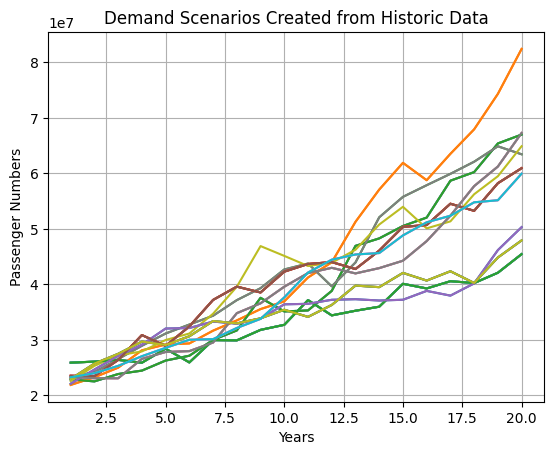

<Figure size 640x480 with 0 Axes>

In [4]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Scenarios,
    Param["Fth"],
    True,
    "Demand Scenarios Created from Historic Data",
    "Passenger Numbers",
    30,
)

Geometric Brownian motion Formula

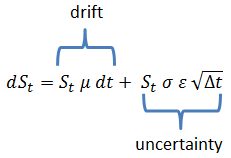

## Estimation of Dockstand Demand

In [5]:
# # Percentage of Pax using Dock Stands rather than Bus Gates
# p_dock = Param["p_dock"]
# # Percentage of Pax travelling within Schengen Area
# p_schengen = Param["p_schengen"]
# # Percentage of Pax travelling from Dock
# p_Dok_A_B = Param["p_Dok_A_B"]
# # average number of passengers carried per air traffic movement
# PAXATM = Param["PAXATM"]


# # Demand at design Hour
# D_per_hour = Demand / (365 * 17)
# ## Contact Stand Demand (ZRH has 75, but not all can be used at once)
# ## Dock A has 17 Contact and 16 Bus Gates

# d = (D_per_hour * p_dock * p_schengen * p_Dok_A_B) / PAXATM
# # print("Contact Stand demad d: ", d)

### Plotting the Dockstand demand

In [6]:
# # Calling the Scenario Plotting Function
# fn.Scenario_plot(
#     d,
#     Param["Fth"],
#     True,
#     "Dockstand Demand Terminal A at ZRH",
#     "Number of Dock Stands",
#     30,
# )

## Calulation of the ENPV

In [7]:
def Capacity(K0, delta_K):
    """
    This Function returns the Capacity value for a given Initial Capacity and delta
    Capacity Vector

    Args:
        K0 (int): Initial Capacity
        delta_K (ndarray): delta Capacity Vector

    Returns:
        K (ndarray): Capacity Vector
    """
    # Create a cumulative sum array starting from K0
    K = K0 + np.cumsum(delta_K) * 1000000
    return K


def Revenue(K, D, r_K, r_K_rent, r_D):
    """
    This Function calculates the Revenue

    Args:
        K (ndarray): Capacity Vector
        D (ndarray): Demand Matrix
        r_K (float): _description_
        r_K_rent (float): _description_
        r_D (float): _description_

    Returns:
        Total_Revenue (float): Revenue
    """
    diff = K - D
    greater_zero = np.greater(diff, 0).astype(int)
    less_equal_zero = np.less_equal(diff, 0).astype(int)
    # if Overcapacity only amount of Demand can be sold
    rev_overcapacity = greater_zero * (D * r_K + D * r_K_rent + D * r_D)
    # if Undercapacity only available Capacity can be sold
    rev_undercapacity = less_equal_zero * (K * r_K + K * r_K_rent + K * r_D)
    Total_Revenue = rev_overcapacity + rev_undercapacity

    return Total_Revenue


def Cost(K, D, delta_K, co_K, co_D, ci_K, EoS, h):
    """
    This Function calculates the Revenue

    Args:
        K (ndarray): Capacity Vector
        D (ndarray): Demand Matrix
        delta_K (ndarray): delta Capacity Vector
        co_K (float): Operating Cost per Unit of Capacity
        co_D (float): Operating Cost per Unit of Demand
        ci_K (float): Installation Cost per Unit of Capaciy
        EoS (float): Economy of Scale Factor
        h (-): _description_

    Returns:
        Total_Cost (float): Cost
    """
    diff = K - D
    # Penalty Cost Overcapacity
    pc_over = 1
    # Penalty Cost Undercapacity
    pc_under = 1
    # Create an Index Matrix with the Condition for undercapacity
    cos_overcapacity = np.greater(diff, 0).astype(int)
    cos_undercapacity = np.less(diff, 0).astype(int)
    cos_equalcapacity = np.equal(diff, 0).astype(int)

    Total_Cost = (
        ((ci_K * (delta_K) ** EoS) / h)
        + cos_undercapacity * (pc_under + (co_D * K + co_K * K))
        + cos_overcapacity * (pc_over + (co_D * D + co_K * D))
        + cos_equalcapacity * (co_D * D + co_K * K)
    )
    return Total_Cost


def NPV_calculation(Revenue, Cost, discount):
    """
    This Function calculates the Net Present Value

    Args:
        Revenue (_type_): Total Revenue
        Cost (_type_): Total Cost
        discount (_type_): discount rate

    Returns:
        NPV (ndarray): Net Present Value
    """
    t = np.arange(0, Param["Fth"], Param["dt"])
    Profit = Revenue - Cost
    Discount = 1 / (1 + discount) ** t
    Present_value = Profit * Discount
    NPV = np.sum(Present_value, axis=1)
    return NPV

In [8]:
def ENPV(delta_K, Param):
    # Parameters
    r_D = Param["r_D"]  # Revenues per Unit of Demand per Period
    r_K = Param["r_K"]  # Revenues per Unit of Capacity per Period
    r_K_rent = Param["r_K_rent"]  # Rental Revenues per Unit of Capacity per Period
    co_K = Param["co_K"]  # Operational costs per unit of capacity per period
    co_D = Param["co_D"]  # Operational cost per unit of demand per period
    ci_K = Param["ci_K"]  # Installation cost per unit of capacity
    discount = Param["discount"]  # Discount factor
    EoS = Param["EoS"]  # EoS factor
    # delta_K0 = 0
    h = Param["h"]
    K0 = Param["K0"]

    # Demand
    D = Demand
    # Capacity Vector
    K = Capacity(K0, delta_K)

    # Revenue
    Rev = Revenue(K, D, r_K, r_K_rent, r_D)

    # Cost
    Cos = Cost(K, D, delta_K, co_K, co_D, ci_K, EoS, h)

    # NPV
    NPV = NPV_calculation(Rev, Cos, discount)

    # ENPV
    ENPV = np.mean(NPV)

    return ENPV  # We use negative ENPV to maximize


# Initial Value for delta_K
delta_K = np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0])

ENPV1 = ENPV(delta_K, Param)
print("ENPV:", ENPV1)

ENPV: 3016584982.3143206


## Optimization Algorithm

In [15]:
initial_vector = delta_K
# np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0])

In [17]:
# Define the bounds for the delta_K
Lower_Limit = 0
Upper_Limit = 10


# Create the DEAP framework
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)


toolbox = base.Toolbox()

# Define the attributes (genes) and their ranges
toolbox.register("attr_float", random.randint, Lower_Limit, Upper_Limit)
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=Param["Fth"],
)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Define the evaluation function
def evaluate(individual, Param=Param):
    return (ENPV(individual, Param=Param),)


# toolbox.register("evaluate", ENPV, Param=Param)

# toolbox.register(
#     "evaluate", flex_valuation_model_dr, d=d, mu=mu, t=param["t"], param=param
# )


toolbox.register("evaluate", evaluate)

# Define the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register(
    "mutate", tools.mutUniformInt, low=Lower_Limit, up=Upper_Limit, indpb=0.2
)

toolbox.register("select", tools.selTournament, tournsize=3)

# Set up the genetic algorithm
population = toolbox.population(n=100)
cxpb, mutpb, ngen = 0.5, 0.2, 10


# Perform the evolution
for gen in range(ngen):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    population[:] = offspring


# Get the best individual
best_ind = tools.selBest(population, 1)[0]
print("Best individual:", best_ind)
print(
    "Best ENPV:", best_ind.fitness.values[0]
)  # Negate the fitness to get the actual NPV value


# Max bei 100:      3264609472.0059185  (0.1s)      [1 2 1 2 7 1 3 10 0 0 1 3 1 2 5 10 1 3 0 5]
# Max bei 10000:    3265986475.3142676  (17s)
# Max bei 100000:   3266071035.747502   (1min 43s)
# Max bei 100000:   3266078549.889531   (1min 48s)  [1 7 0 0 0 0 8 0 9 6 0 0 8 3 0 0 0 8 0 9]
# Max bei 100000:   3266032943.8812723  (2min 10s)  [1 1 6 0 0 0 9 0 7 0 0 1 7 2 3 0 6 9 2 3]
# Max bei 100000:   3265887785.211231   (2min 10s)  [1 6 0 0 0 10 5 0 0 3 1 1 0 10 0 2 0 6 8 3]

Best individual: [ 1  2  1  2  7  1  3 10  0  0  1  3  1  2  5 10  1  3  0  5]
Best ENPV: 3264609472.0059185


Plotting the Results of the Optimization

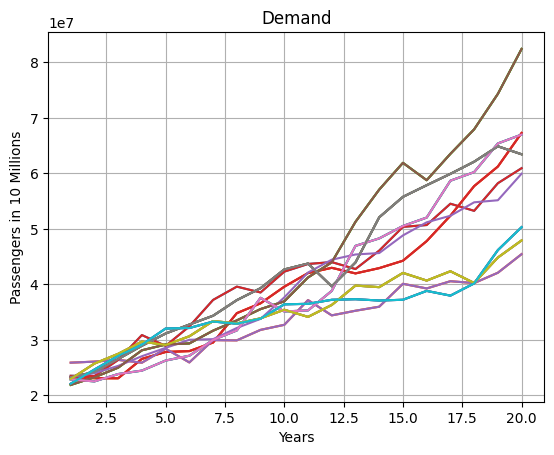

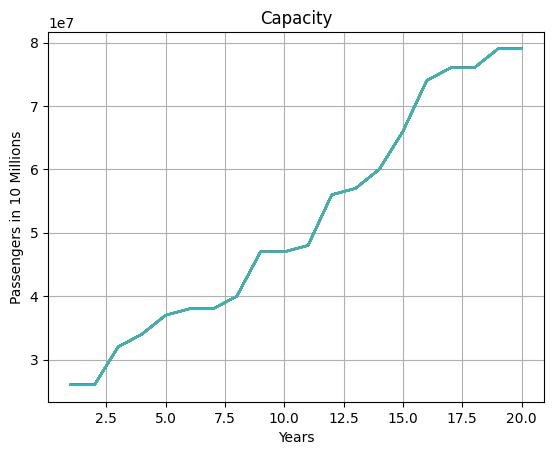

<Figure size 640x480 with 0 Axes>

In [11]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Demand,
    Param["Fth"],
    True,
    "Demand",
    "Passengers in 10 Millions",
    30,
)

New_K = Capacity(Param["K0"], best_ind)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    New_K,
    Param["Fth"],
    True,
    "Capacity",
    "Passengers in 10 Millions",
    30,
)

In [12]:
r_D = Param["r_D"]  # Revenues per Unit of Demand per Period
r_K = Param["r_K"]  # Revenues per Unit of Capacity per Period
r_K_rent = Param["r_K_rent"]  # Rental Revenues per Unit of Capacity per Period
co_K = Param["co_K"]  # Operational costs per unit of capacity per period
co_D = Param["co_D"]  # Operational cost per unit of demand per period
ci_K = Param["ci_K"]  # Installation cost per unit of capacity
discount = Param["discount"]  # Discount factor
EoS = Param["EoS"]  # EoS factor
# delta_K0 = 0
h = Param["h"]
K0 = Param["K0"]

# Demand


# Capacity Vector
K2 = Capacity(Param["K0"], best_ind)

# Revenue
Rev = Revenue(K2, Demand, r_K, r_K_rent, r_D)

# Cost
Cos = Cost(K2, Demand, best_ind, co_K, co_D, ci_K, EoS, h)

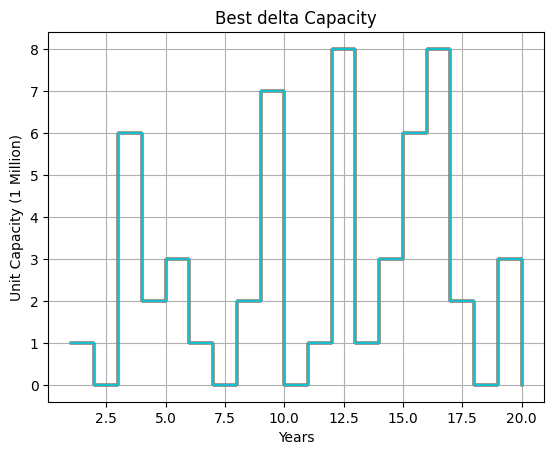

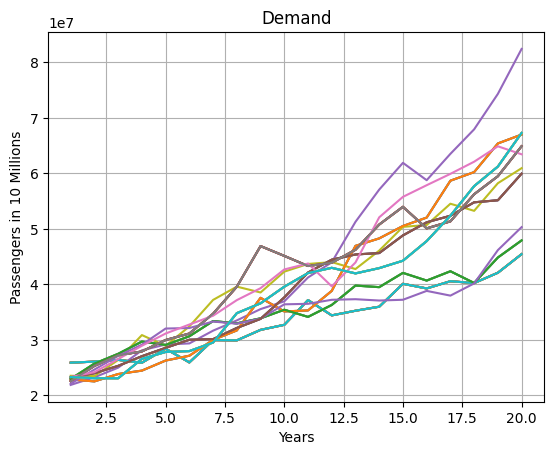

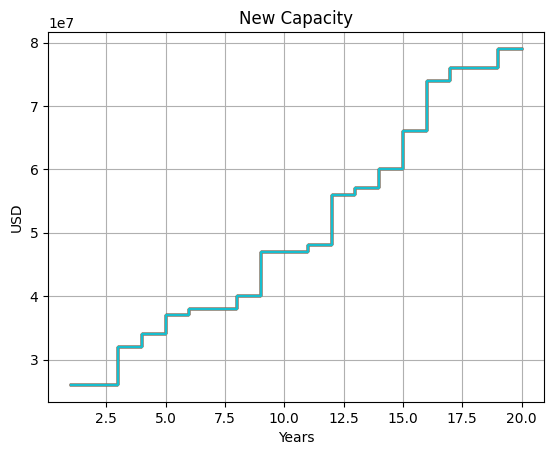

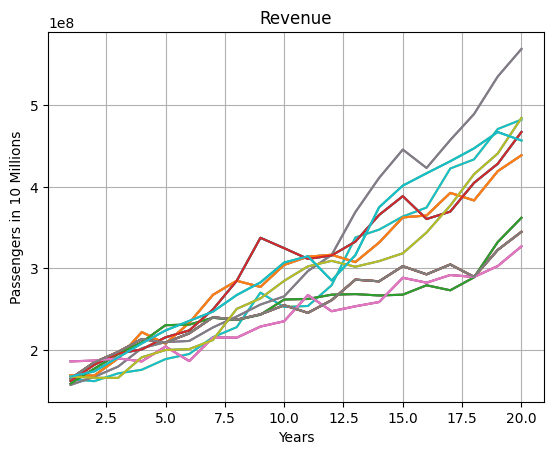

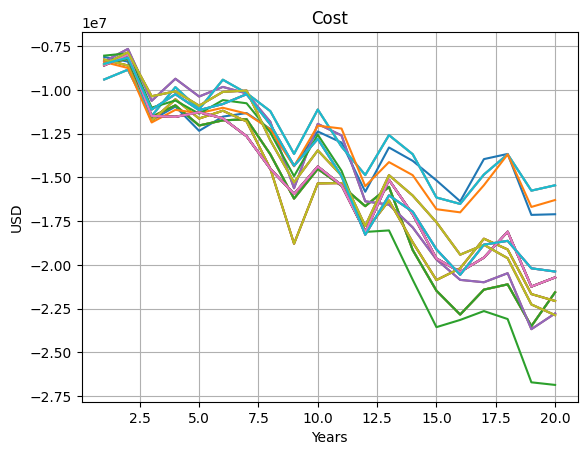

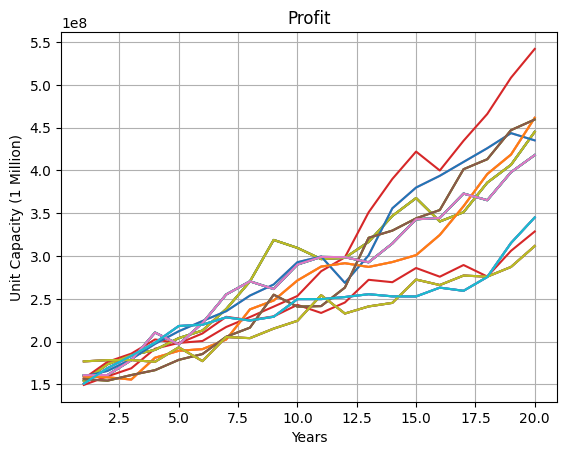

<Figure size 640x480 with 0 Axes>

In [13]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    best_ind,
    Param["Fth"],
    False,
    "Best delta Capacity",
    "Unit Capacity (1 Million)",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Demand,
    Param["Fth"],
    True,
    "Demand",
    "Passengers in 10 Millions",
    30,
)

# Calling the Scenario Plotting Function
fn.Scenario_plot(
    K2,
    Param["Fth"],
    False,
    "New Capacity",
    "USD",
    30,
)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Rev,
    Param["Fth"],
    True,
    "Revenue",
    "Passengers in 10 Millions",
    30,
)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    -Cos,
    Param["Fth"],
    True,
    "Cost",
    "USD",
    30,
)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    (Rev - Cos),
    Param["Fth"],
    True,
    "Profit",
    "Unit Capacity (1 Million)",
    30,
)

### Stopping the Runtime

In [14]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", total_run_time)

Total Runtime = 1.8537743091583252
